ls


In [22]:
ls

 Volume in drive D is New Volume
 Volume Serial Number is EE85-DBB6

 Directory of D:\2022_GeoAI_Martian_Challenge_Dataset\2022_GeoAI_Martian_Challenge_Dataset

07-04-2022  16:19    <DIR>          .
07-04-2022  16:19    <DIR>          ..
06-04-2022  18:40    <DIR>          .ipynb_checkpoints
24-03-2022  19:54    <DIR>          __pycache__
07-04-2022  10:17       770,654,750 detection_results.json
25-02-2022  20:37             1,447 evaluate.py
25-02-2022  20:36        24,783,564 gt_eval.json
25-02-2022  20:35         4,420,009 gt_public.json
25-02-2022  20:35         1,067,872 ids.json
16-03-2022  10:51    <DIR>          images
07-04-2022  16:19           214,838 Mars_Crater_Detection.ipynb
07-04-2022  10:17           251,867 Mars_Crater_Detection-Copy1.ipynb
25-03-2022  17:22             2,150 Untitled1.ipynb
04-04-2022  13:13             1,356 Untitled2.ipynb
               9 File(s)    801,397,853 bytes
               5 Dir(s)  1,465,983,090,688 bytes free


In [23]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [24]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [25]:
import torch  
import json
import math
import copy
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

[WinError 2] The system cannot find the file specified: 'demo'
D:\2022_GeoAI_Martian_Challenge_Dataset\2022_GeoAI_Martian_Challenge_Dataset
image id: 045500


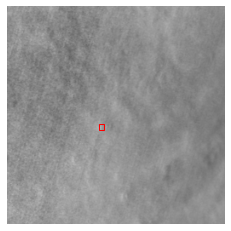

In [26]:
#function to show one image and its crater labels
import cv2
def imshow(image, labels):
  fig, ax = plt.subplots()
  ax.imshow(image, cmap='gray')

  for box in labels:
    # box format: [xmin, ymin, width, height]
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  plt.axis('off')
  plt.show()

# change directory
%cd demo
# load image IDs from ids_demo.json
image_ids = json.load(open("./ids.json"))
# get IDs of the training set
train_set_ids = image_ids["train"]
# load one sample image
sample_image_id = train_set_ids[random.randrange(len(train_set_ids))]
sample_image = cv2.imread("./images/{}.png".format(sample_image_id))
# load crater labels from gt_public.json
labels = json.load(open("./gt_public.json"))
# load the label for the sample image 
sample_label = labels[sample_image_id]
print("image id: {}".format(sample_image_id))
imshow(sample_image, sample_label)

In [28]:
def get_object_detection_model(num_classes):
  model = models.detection.retinanet_resnet50_fpn(num_classes=num_classes)
  return model

In [29]:
class CraterDataset(Dataset):
  def __init__(self, phase, data_transforms):
    self.transform = data_transforms
    # load image IDs of training set or validation set
    self.img_ids = json.load(open('./ids.json'))[phase]
    # load all crater bounding boxes
    self.crater_boxes = json.load(open('./gt_public.json'))


  def __getitem__(self, idx): 
    img_id = self.img_ids[idx]
    # load the image
    img = cv2.imread("./images/{}.png".format(img_id)) 
    # get bounding boxes and transfer it 
    # from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax] 
    crater_boxes = self.crater_boxes[img_id]
    num_craters = len(crater_boxes)
    boxes = []
    for box in crater_boxes:
        xmin = box[0]
        xmax = box[0] + box[2]
        ymin = box[1]
        ymax = box[1] + box[3]
        boxes.append([xmin, ymin, xmax, ymax])

    # tranfser to requested data type
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # the class of all boxes is the same. 0: background 1: crater
    labels = torch.ones((num_craters,), dtype=torch.int64)
    # wrap up as a dictionary 
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    # data transform 
    if self.transform is not None:
        img = self.transform(img)

    return img, target
    
  
  def __len__(self):
    return len(self.img_ids)


In [30]:
def train_model(model, optimizer, dataset, data_loader, num_epochs=10):
  since = time.time()
  # check if gpu is available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  print('training with gpu...' if torch.cuda.is_available() else 'trining with cpu...')
  # store best model weights
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100000
  model.train()

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      running_loss = 0.0

      # iterate over data
      for images, targets in data_loader[phase]:
        # transfer data into requested input format of RetinaNet
        # transfer data to gpu if available
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # loss calculation
        losses = model(images, targets)
        losses = sum(loss for loss in losses.values())

        # update the model only in the training phase
        # gradient back propagation + model parameters update
        if phase == 'train':
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        # accumulate loss values
        running_loss += losses.item() * len(images)
      
      # average loss   
      epoch_loss = running_loss / len(dataset[phase])
      print('{} loss: {:.4f}'.format(phase, epoch_loss))

      # select the best model in the validation phase
      # copy the model weights if loss is smaller
      if phase == 'val' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
          
    print('-' * 10)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best validation loss: {:4f}'.format(best_loss))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [47]:
import torch
torch.cuda.empty_cache()

In [48]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 9            |        cudaMalloc retries: 13        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    6742 MB |    6813 MB |     945 TB |     945 TB |\n|       from large pool |    6583 MB |    6649 MB |     933 TB |     933 TB |\n|       from small pool |     158 MB |     195 MB |      11 TB |      11 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |    6742 MB |    6813 MB |     945 TB |     945 TB |\n|       from large pool |    6583 MB |    6649 MB |

In [49]:
# initialize a model with numer of classes = 2
model = get_object_detection_model(2)
# define data tranformation function
data_transforms = transforms.Compose([transforms.ToTensor()])
# define dataset and dataloader for training for debug set
dataset = {x: CraterDataset(x, data_transforms) for x in ['train', 'val']}
data_loader = {x: DataLoader(dataset[x], batch_size=4, 
                             shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
for x in ['train', 'val']}
# transfer the model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# define optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# train model
model = train_model(model, optimizer, dataset, data_loader, num_epochs=20)

training with gpu...
Epoch 0/19
----------
train loss: 0.8404
val loss: 0.4730
----------
Epoch 1/19
----------
train loss: 0.4590
val loss: 0.4657
----------
Epoch 2/19
----------
train loss: 0.4306
val loss: 0.4351
----------
Epoch 3/19
----------
train loss: 0.4134
val loss: 0.4310
----------
Epoch 4/19
----------
train loss: 0.3996
val loss: 0.4230
----------
Epoch 5/19
----------
train loss: 0.3885
val loss: 0.4282
----------
Epoch 6/19
----------
train loss: 0.3764
val loss: 0.4254
----------
Epoch 7/19
----------
train loss: 0.3644
val loss: 0.4303
----------
Epoch 8/19
----------
train loss: 0.3526
val loss: 0.4314
----------
Epoch 9/19
----------
train loss: 0.3405
val loss: 0.4449
----------
Epoch 10/19
----------
train loss: 0.3283
val loss: 0.4620
----------
Epoch 11/19
----------
train loss: 0.3168
val loss: 0.4638
----------
Epoch 12/19
----------
train loss: 0.3067
val loss: 0.4641
----------
Epoch 13/19
----------
train loss: 0.2948
val loss: 0.4729
----------
Epoch 14/

image id: 023351


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

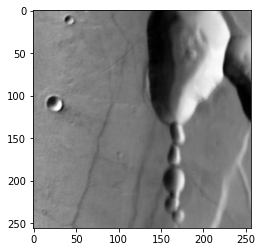

In [50]:
# set the model in the evaluation model
model.eval()
# load testing image IDs
test_img_ids = json.load(open('./ids.json'))['test']
# load one sample image
test_img_id = test_img_ids[random.randrange(len(test_img_ids))]
test_img = cv2.imread('./images/{}.png'.format(test_img_id))
# apply data transformation ToTensor() and send the image to gpu if available
transformed_test_img = data_transforms(test_img)
transformed_test_img = transformed_test_img.to(device)
# turn of the gradient computation and make prediction
with torch.no_grad():
  prediction = model([transformed_test_img])

# keep boxes with scores >= 0.5
boxes = prediction[0]["boxes"]
scores = prediction[0]["scores"]
boxes = boxes[scores >= 0.5, :]
# box format transformation
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
# plot image
print("image id: {}".format(test_img_id))
imshow(test_img, boxes)

In [51]:
pip install pycocotools-windows

You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [52]:
# set the model in evaluation model                                
model.eval()
# load image IDs of the validation set
val_img_ids = json.load(open('./ids.json'))['val']
detection_results = {}

# iterate over the validation set
for img_id in val_img_ids:
  val_img = cv2.imread('./images/{}.png'.format(img_id))
  # apply data transformation ToTensor() and send the image to gpu if available
  transformed_val_img = data_transforms(val_img)
  transformed_val_img = transformed_val_img.to(device)
  # turn of the gradient computation and make prediction
  with torch.no_grad():
    prediction = model([transformed_val_img])

  # box format transformation
  boxes = prediction[0]["boxes"]
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
  scores = prediction[0]["scores"]
  scores = torch.reshape(scores, (-1,1))
  # concatenate boxes and scores
  # the result format is [xmin, ymin, width, height, score]
  boxes_scores = torch.cat((boxes, scores), dim=1)
  # transfer to list and store in the dictionary 
  boxes_scores = boxes_scores.cpu().numpy().tolist()
  detection_results[img_id] = boxes_scores

# import evaluate function
from evaluate import evaluate
print('evaluation metrics: ')
metrics = evaluate(detection_results)
print()
print('the list of evaluation values: {}'.format(metrics))


evaluation metrics: 
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.19s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.195
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

In [53]:
# set the model in evaluation model                                
model.eval()
# load image IDs of the testing set
test_img_ids = json.load(open('./ids.json'))['test']
detection_results = {}

# iterate over the testing set
for img_id in test_img_ids:
  test_img = cv2.imread('./images/{}.png'.format(img_id))
  # apply data transformation ToTensor() and send the image to gpu if available
  transformed_test_img = data_transforms(test_img)
  transformed_test_img = transformed_test_img.to(device)
  # turn of the gradient computation and make prediction
  with torch.no_grad():
    prediction = model([transformed_test_img])

  # box format transformation
  boxes = prediction[0]["boxes"]
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
  scores = prediction[0]["scores"]
  scores = torch.reshape(scores, (-1,1))
  # concatenate boxes and scores
  # the result format is [xmin, ymin, width, height, score]
  boxes_scores = torch.cat((boxes, scores), dim=1)
  # transfer to list and store in the dictionary 
  boxes_scores = boxes_scores.cpu().numpy().tolist()
  detection_results[img_id] = boxes_scores

# save the result to file
with open('detection_results.json', 'w') as f:
  json.dump(detection_results, f)

# zip the result
#!zip detection_results.zip detection_results.json

In [20]:
testImage=sample_image = cv2.imread("./images/031950.png")
output=(testImage)

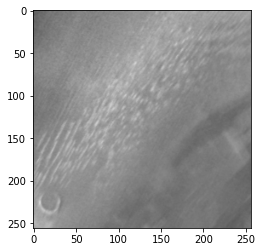

In [21]:
plt.imshow(testImage)

In [22]:
model.eval()
# load testing image IDs
#test_img_ids = json.load(open('./ids.json'))['test']
# load one sample image
#test_img_id = test_img_ids[random.randrange(len(test_img_ids))]
test_img = cv2.imread("./images/031950.png")
# apply data transformation ToTensor() and send the image to gpu if available
transformed_test_img = data_transforms(test_img)
transformed_test_img = transformed_test_img.to(device)
# turn of the gradient computation and make prediction
with torch.no_grad():
  prediction=model([transformed_test_img])


In [41]:
boxes=prediction[0]['boxes'].cpu().numpy()

In [50]:
prediction

[{'boxes': tensor([[  8.1964, 211.1441,  32.8779, 235.9704],
          [  2.2957, 213.5467,  25.0518, 237.2904],
          [  6.1464, 217.9179,  29.4427, 242.1095],
          [ 10.7785, 208.1325,  30.8322, 227.8956]], device='cuda:0'),
  'scores': tensor([0.7793, 0.1096, 0.0815, 0.0506], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0')}]

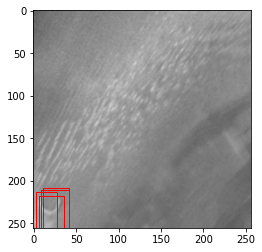

In [48]:
fig,axes=plt.subplots()
plt.imshow(testImage)
for i in range(boxes.shape[0]):
    xmin=boxes[i,0]
    ymin=boxes[i,1]
    patch=patches.Rectangle((xmin,ymin),boxes[i,2],boxes[i,3],facecolor='None',edgecolor='red')
    axes.add_patch(patch)

In [35]:
prediction.np()

AttributeError: 'list' object has no attribute 'np'